In [1]:
import os
import json
import pickle

import pandas as pd
pd.options.display.max_colwidth = 200

import numpy as np
from numpy import mean
from collections import Counter
import re
import regex
import random

from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns


KeyboardInterrupt: 

In [ ]:
output_path = os.path.join(os.getcwd(), 'individualistic_vs_collective')
input_path = os.path.join(os.getcwd(), 'Data', 'pickled_big_file')

with open(input_path, 'rb') as pickle_file:
  df = pickle.load(pickle_file)

df.head(1)

,opinion_num,category,author,case,year,text,sent_index,length,sent_location,percent_letter,predictions,prob_0,prob_1,monologic_prediction,sentence_length,chief_justice,key,mono_type
0,0,Majority,Justice Roberts,McCutcheon v. Federal Election Comm'n,2014,There is no right more basic in our democracy than the right to participate in electing our political leaders.,0,539,0.0,82.727273,"[0.07450004667043686, 0.9254999756813049]",0.0745,0.9255,1,110.0,Roberts,1,1.0


In [ ]:
df['individualistic'] = np.where(df['mono_type'] == 0, 1, 0)
df['collective'] = np.where(df['mono_type'] == 1, 1, 0)

In [ ]:
def plot_ratio(df, y_value = "monologic_prediction", y_axis = "Monologic Value"):
    sns.set(style='ticks', font_scale=2)
    sns.set_palette(sns.color_palette("colorblind"))
    colorblind = ["#0072B2", "#009E73", "#D55E00","#CC79A7"]
    palette ={"Majority": colorblind[0], "Per Curiam": colorblind[1], "Concurring": colorblind[2], "Dissenting": colorblind[3]}
    
    plt.figure(figsize=(15,10))
    sns.barplot(data=df, 
                x="category", 
                y=y_value,
                estimator=mean,
                hue = "category",
                order=["Majority","Per Curiam", "Dissenting", "Concurring"],
                palette = palette,
                dodge=False
               )

    plt.xlabel('Category', fontsize = 30)
    plt.ylabel(y_axis, fontsize = 30)
    sns.despine()
    plt.legend([],[], frameon=False)
    plt.savefig(os.path.join(output_path, y_value + 'by_opinion'), dpi = 300)
    plt.show()


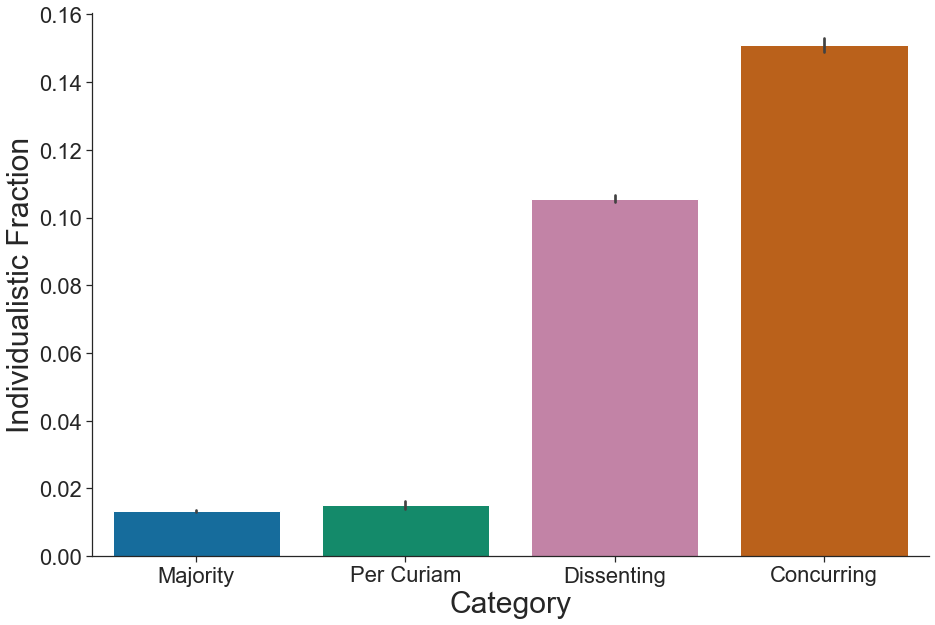

In [ ]:
plot_ratio(df, y_value = "individualistic", y_axis= "Individualistic Fraction")

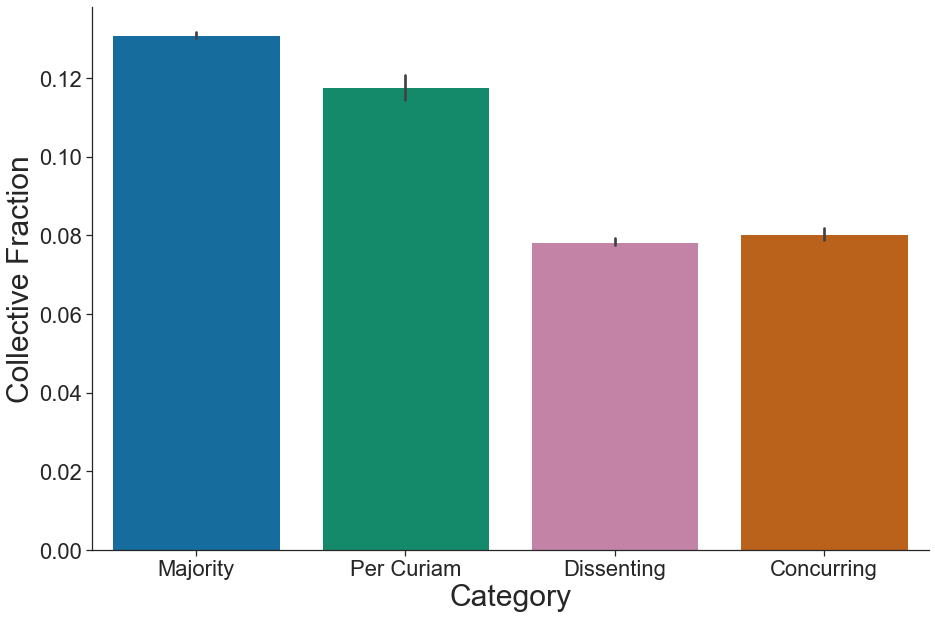

In [ ]:
plot_ratio(df, y_value = "collective", y_axis= "Collective Fraction")

In [ ]:
# drop error names
per_curiam = ["per_curiam", "Justice Vinson"]
df_filtered = df[~df['author'].isin(per_curiam)]
df_filtered = df_filtered.drop(df_filtered[(df_filtered['author'] == "Justice Jackson") & (df_filtered['year'] == 1964)].index)


In [ ]:
# SPLIT SCALIA, O'CONNOR, THOMAS, KENNEDY, GINSBURG, BREYER, SOUTER, STEVENS
df_filtered["author"].replace("Justice ",'',regex=True, inplace = True)

roberts_court = pd.DataFrame(["Stevens", "O'Connor", "Scalia", "Kennedy", "Souter", "Thomas", "Ginsburg", "Breyer"])
roberts_court["roberts_justice"] = "Rehnquist - Roberts Court"
roberts_court = roberts_court.rename(columns = {0:"author"})

only_roberts = pd.DataFrame(["Roberts", "Alito", "Sotomayor", "Kagan", "Gorsuch", "Kavanaugh" ])
only_roberts["roberts_justice"] = "Roberts Court"
only_roberts = only_roberts.rename(columns = {0:"author"})

# stack them
roberts_frames = [only_roberts, roberts_court]
roberts_combined_df = pd.concat(roberts_frames)

# combine with filter
df_filtered = df_filtered.merge(roberts_combined_df, on = "author", how = "left")
df_filtered["roberts_justice"] = df_filtered["roberts_justice"].fillna("Not Roberts Court")



In [ ]:
def check_if_roberts(author, year, roberts_justice):
    if roberts_justice == "Rehnquist - Roberts Court":
        if year > 2006:
            new_author = "post-" + author
        else:
            new_author = "pre-" + author
    else:
        new_author = author
    return new_author

In [ ]:
def change_roberts_col(author, year, roberts_justice):
    if roberts_justice == "Rehnquist - Roberts Court":
        if year > 2006:
            court = "Bridging Justice (post-Rehnquist)"
        else:
            court = "Bridging Justice (pre-Rehnquist)"
    else:
        court = roberts_justice
    return court

In [ ]:
df_filtered['split_author'] = df_filtered.apply(lambda x: check_if_roberts(x['author'], x['year'], x["roberts_justice"]), axis=1)

In [ ]:
df_filtered.author.unique()

AttributeError: 'DataFrame' object has no attribute 'court'

In [ ]:
df_filtered['court'] = df_filtered.apply(lambda x: change_roberts_col(x['author'], x['year'], x["roberts_justice"]), axis=1)

In [ ]:
df_filtered.court.unique()

array(['Roberts Court', 'Bridging Justice (post-Rehnquist)',
       'Not Roberts Court', 'Bridging Justice (pre-Rehnquist)'],
      dtype=object)

In [ ]:
# of all of the monologic voice that they use, how much of it is individualistic vs collective? 
# of all of the sentences they write, how probable is it that a sentence will be individualistic? 

df_indi = df_filtered.groupby(['opinion_num', 'category','split_author', 'case', 'year', 'court', 'roberts_justice'])['individualistic'].mean().reset_index()
df_collective = df_filtered.groupby(['opinion_num', 'category','split_author', 'case', 'year',  'court', 'roberts_justice'])['collective'].mean().reset_index()


In [ ]:
# then get author's individualistic mean by opinion
df_author_indi = pd.DataFrame(df_indi.groupby(['split_author', 'court'])['individualistic'].mean()).reset_index()
df_author_collective = pd.DataFrame(df_collective.groupby(['split_author', 'court'])['collective'].mean()).reset_index()


In [ ]:
# this can become a heatmap
combined_means = pd.merge(df_author_indi, df_author_collective, on = "split_author")

In [ ]:
combined_means

,split_author,court_x,individualistic,court_y,collective
0,Alito,Roberts Court,0.077145,Roberts Court,0.106245
1,Black,Not Roberts Court,0.131507,Not Roberts Court,0.110222
2,Blackmun,Not Roberts Court,0.152218,Not Roberts Court,0.076526
3,Brennan,Not Roberts Court,0.132021,Not Roberts Court,0.100975
4,Burger,Not Roberts Court,0.107573,Not Roberts Court,0.105267
5,Burton,Not Roberts Court,0.061692,Not Roberts Court,0.088288
6,Clark,Not Roberts Court,0.064089,Not Roberts Court,0.123207
7,Douglas,Not Roberts Court,0.088053,Not Roberts Court,0.112451
8,Fortas,Not Roberts Court,0.101816,Not Roberts Court,0.113241
9,Frankfurter,Not Roberts Court,0.086220,Not Roberts Court,0.099758


In [ ]:
combined_means = combined_means.set_index('split_author')
combined_means.sort_values(by = "collective")

,court_x,individualistic,court_y,collective
split_author,,,,
post-Kennedy,Bridging Justice (post-Rehnquist),0.040793,Bridging Justice (post-Rehnquist),0.048068
Whittaker,Not Roberts Court,0.109402,Not Roberts Court,0.072026
Goldberg,Not Roberts Court,0.126398,Not Roberts Court,0.075125
post-Ginsburg,Bridging Justice (post-Rehnquist),0.058665,Bridging Justice (post-Rehnquist),0.076277
Rutledge,Not Roberts Court,0.140373,Not Roberts Court,0.076481
Blackmun,Not Roberts Court,0.152218,Not Roberts Court,0.076526
Stewart,Not Roberts Court,0.104771,Not Roberts Court,0.085326
Harlan,Not Roberts Court,0.236745,Not Roberts Court,0.087743
Burton,Not Roberts Court,0.061692,Not Roberts Court,0.088288


In [ ]:
combined_means = combined_means[combined_means.index != "Harlan"]

In [ ]:
def scatter_justices_contrast_cols(df, majority_col, minority_col, hue_col):
    plt.figure(figsize=(15,15))
    palette ={"Roberts Court": "#d7b3db", "Not Roberts Court":"#c6e4e1", "Bridging Justice (pre-Rehnquist)":"#43A59D", "Bridging Justice (post-Rehnquist)": "#9d43a5"} 


    g = sns.scatterplot(data=df, 
                    x=majority_col, 
                    y=minority_col, 
                    s = 200, 
                    hue = hue_col, 
                    #style = style_col,
                    palette = palette
                    )

    for i in range(df.shape[0]):
        plt.text(x=df.collective[i]+.0005,y=df.individualistic[i]+.001,s=df.index[i], 
             fontdict=dict(color='black', size=12))
             
    connections = [
        ["pre-Scalia", "post-Scalia"], 
        ["pre-Ginsburg", "post-Ginsburg"], 
        ["pre-Stevens", "post-Stevens"], 
        ["pre-Kennedy", "post-Kennedy"], 
        ["pre-Souter", "post-Souter"],
        ["pre-Thomas", "post-Thomas"],
        ["pre-Breyer", "post-Breyer"]
        ]

    for name in connections:
        x_point_1 = combined_means[combined_means.index == name[0]].collective.tolist()[0]
        y_point_1 = combined_means[combined_means.index == name[0]].individualistic.tolist()[0]
        x_point_2 = combined_means[combined_means.index == name[1]].collective.tolist()[0]
        y_point_2 = combined_means[combined_means.index == name[1]].individualistic.tolist()[0]
        x_values = [x_point_1, x_point_2]
        y_values = [y_point_1, y_point_2]
        #plt.plot(x_values, y_values, marker = '*', markevery=(x_point_2, y_point_2), color = 'black', alpha = .2, markersize = 10) 
        plt.plot(x_values, y_values, linestyle = '--', color = 'black', alpha = .2, markersize = 2)  
    
    point1 = [.01, .01]
    point2 = [.275, .275]

    x_values = [point1[0], point2[0]]

    y_values = [point1[1], point2[1]]
    
    #plt.plot(x_values, y_values, linestyle = '--', color = 'lightgrey')

    plt.xlabel("Collective Voice Fraction")
    plt.ylabel("Individualistic Voice Fraction")

    legend = plt.legend(loc='upper left', title='')


    plt.xlim(0.02, .16)
    plt.ylim(0.02, .16)
    
    
    plt.savefig(output_path + '/by_justice_scatter', dpi = 300);

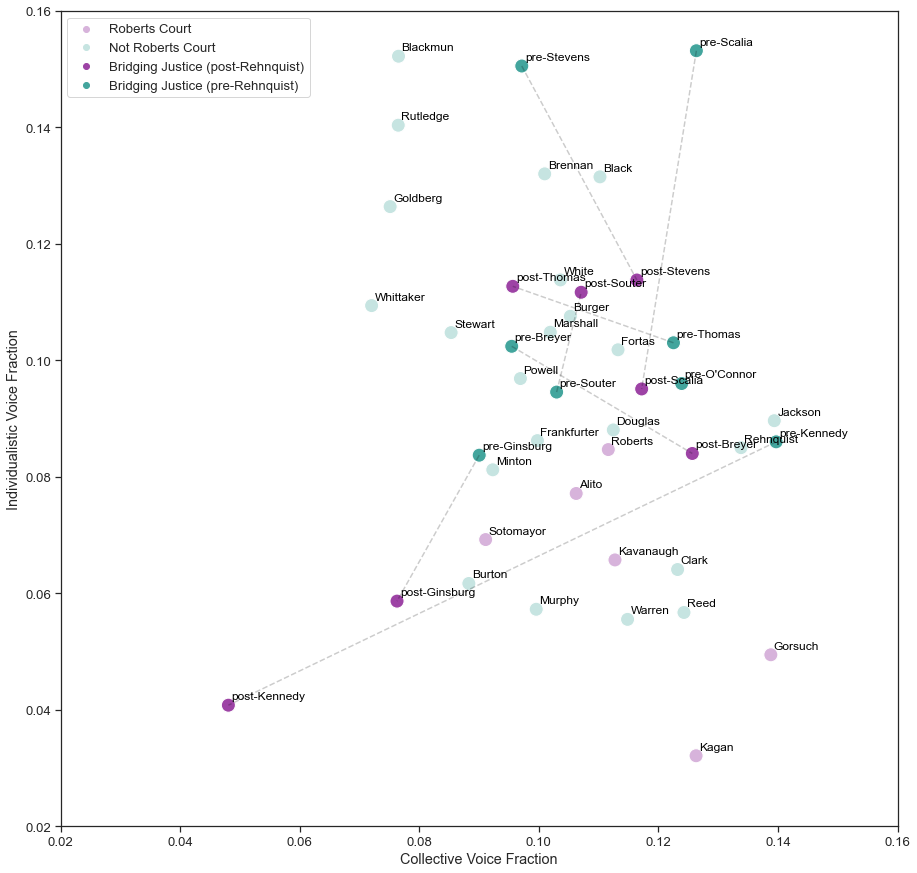

In [ ]:
scatter_justices_contrast_cols(combined_means, 'collective', 'individualistic',  "court_y")

In [ ]:
# changes over time
def plot_sentences_over_years(df):
    sns.set(style='ticks', font_scale=1.2)
    plt.figure(figsize=(14,10))
    sns.lineplot(data=df,
                x="year", 
                y='monologic_prediction',
                estimator=mean, 
                color='cornflowerblue')
    sns.lineplot(data=df,
            x="year", 
            y='individualistic',
            estimator=mean, 
            color='red')
    sns.lineplot(data=df,
            x="year", 
            y='collective',
            estimator=mean, 
            color='green')

    # set xlim
    chief_years = [1946, 1953, 1969, 1986, 2005]
    chief_names = ["Vinson", "Warren", "Burger", "Rehnquist", "Roberts"]
    for y, n in zip(chief_years, chief_names):
        plt.axvline(y, color='0.8')
        plt.text(x=y+.5, y=.21, s=n, color='black')
    plt.xticks(np.arange(1945, 2020, 10))
    plt.xlabel('Case Year', labelpad=20, fontsize = 17)
    plt.ylabel('Monologic Concentration', labelpad=20, fontsize = 17)
    #plt.title("Monologic Voice Over Terms", fontsize=20, y = 1.2)
    plt.tight_layout()
    sns.despine()
    plt.savefig(output_path + '/over_time', dpi = 300)
    plt.show()

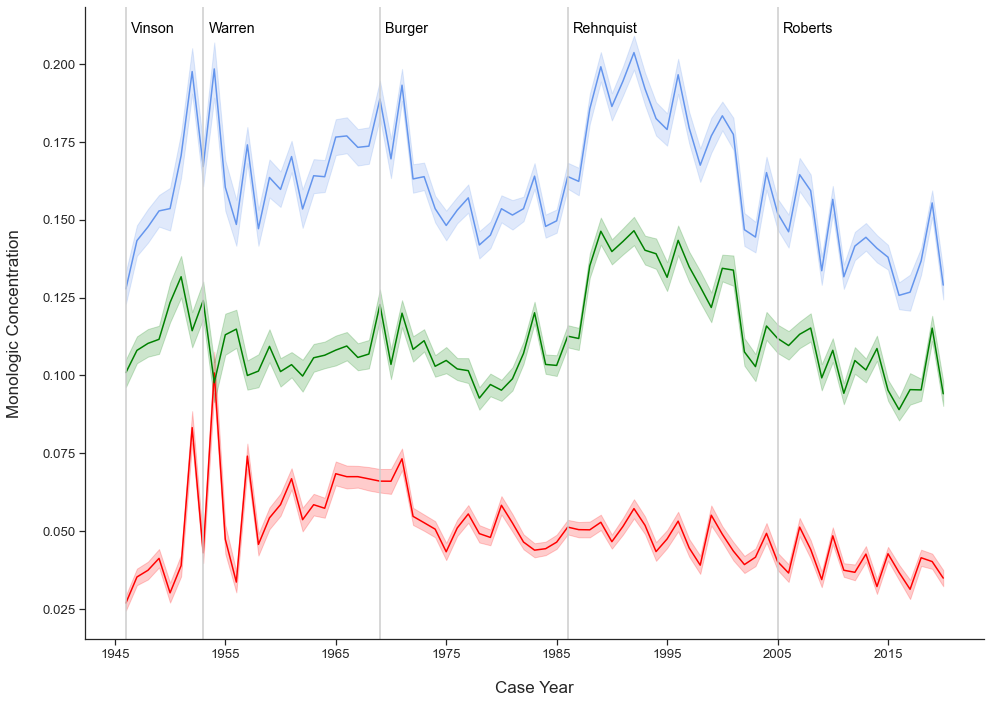

In [ ]:
plot_sentences_over_years(df)

In [ ]:
roberts_court = pd.DataFrame(["Stevens", "O'Connor", "Scalia", "Kennedy", "Souter", "Thomas", "Ginsburg", "Breyer", "Roberts", "Alito", "Sotomayor", "Kagan", "Gorsuch", "Kavanaugh" ])
roberts_court["roberts_justice"] = "Roberts Court"

roberts_court = roberts_court.rename(columns = {0:"author"})


## Author Information

In [ ]:
collective_by_opinion = pd.DataFrame(df_filtered.groupby(['opinion_num', 'author', 'year'])['collective'].mean()).reset_index()
individualistic_by_opinion = pd.DataFrame(df_filtered.groupby(['opinion_num', 'author', 'year'])['individualistic'].mean()).reset_index()
overall_by_opinion =  pd.DataFrame(df_filtered.groupby(['opinion_num', 'author', 'year'])['monologic_prediction'].mean()).reset_index()

In [ ]:
zscore = lambda x: (x - x.mean()) / x.std()

# group by opinion category and find z scores
collective_by_opinion.insert(1, 'z-score-collective', collective_by_opinion['collective'].transform(zscore))
individualistic_by_opinion.insert(1, 'z-score-individualistic', individualistic_by_opinion["individualistic"].transform(zscore))
overall_by_opinion.insert(1, 'z-score-overall', overall_by_opinion["monologic_prediction"].transform(zscore))

# calculate overall mean of opinion z scores
author_zscores_collective_overall = pd.DataFrame(collective_by_opinion.groupby('author')['z-score-collective'].mean()).reset_index()
author_zscores_individualistic_overall = pd.DataFrame(individualistic_by_opinion.groupby('author')['z-score-individualistic'].mean()).reset_index()
author_zscores_overall = pd.DataFrame(overall_by_opinion.groupby('author')['z-score-overall'].mean()).reset_index()


In [ ]:
combined_z_scores = author_zscores_overall.merge(author_zscores_collective_overall, on = "author")
combined_z_scores = combined_z_scores.merge(author_zscores_individualistic_overall, on = "author")
combined_z_scores["author"].replace("Justice ",'',regex=True, inplace = True)
combined_z_scores = combined_z_scores.set_index("author")

combined_z_scores
combined_z_scores = combined_z_scores.sort_values(by=['z-score-individualistic'], ascending=False)

In [ ]:
combined_z_scores

,z-score-overall,z-score-collective,z-score-individualistic
author,,,
Harlan,0.667136,-0.220627,0.723503
Blackmun,0.083557,-0.361823,0.241879
Stevens,0.191219,-0.084646,0.217065
Rutledge,0.011085,-0.362399,0.174392
Scalia,0.277126,0.232773,0.153700
Brennan,0.109475,-0.054055,0.126805
Black,0.162700,0.062348,0.123872
Goldberg,-0.082361,-0.379459,0.094761
White,0.014518,-0.020950,0.023054


In [ ]:
def plot_heatmap_by_category(df):
    sns.set(style='ticks', font_scale=1.2)
    plt.subplots(figsize=(10,15)) 
    mask = df.isnull()
    column_labels = ["Overall", "Collective", "Individualistic"]
    cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True, reverse=True)
    graph = sns.heatmap(df, 
                robust=True,
                mask=mask,
                xticklabels=column_labels,
                cmap = "Blues"
               )
    graph.set_facecolor('lightgrey')
    plt.ylabel(' ')
    plt.tight_layout()
    sns.despine()
    plt.savefig(output_path + '/by_justice', dpi = 300)
    plt.show()

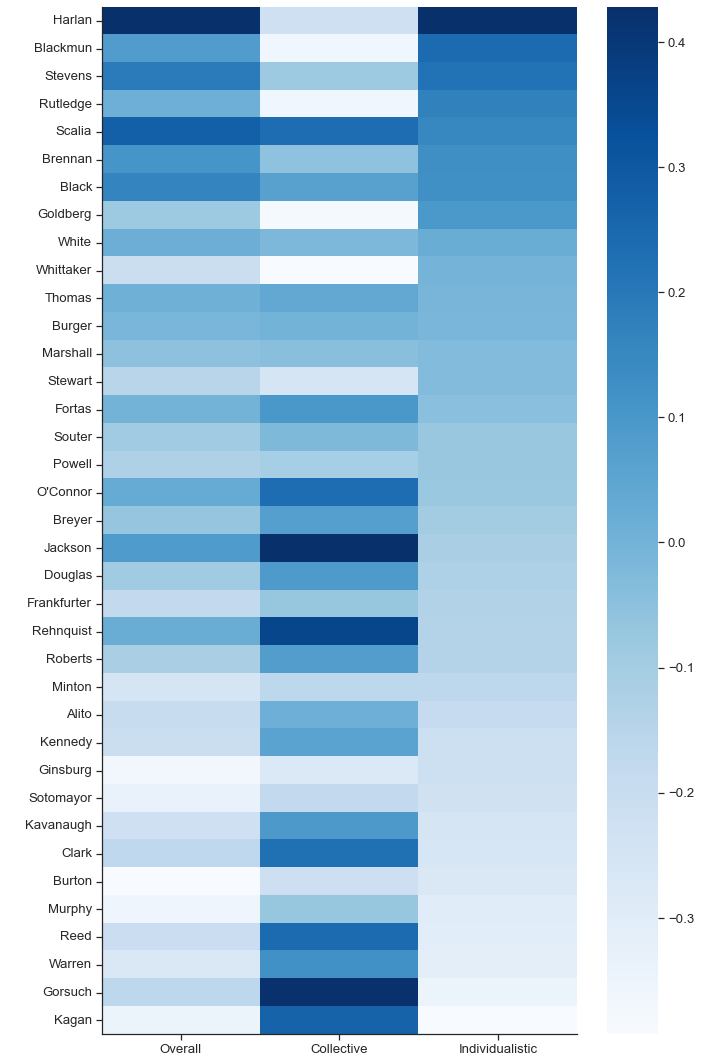

In [ ]:
plot_heatmap_by_category(combined_z_scores)

In [ ]:
author_overall_individualistic = pd.DataFrame(individualistic_by_opinion.groupby(['author'])["individualistic"].mean()).reset_index()
author_overall_collective = pd.DataFrame(collective_by_opinion.groupby(['author'])["collective"].mean()).reset_index()

combined_overall_types = author_overall_collective.merge(author_overall_individualistic, on = "author")

In [ ]:
author_by_year_individualistic = df.groupby(['author','year', 'category'], as_index=False)['individualistic'].mean()
author_by_year_collective = df.groupby(['author','year', 'category'], as_index=False)['collective'].mean()

In [ ]:
def trends_over_years_by_author(df, year_col, prediction_col, category_col):
    sns.set(style='ticks', font_scale=2)
    colorblind = ["#0072B2", "#009E73", "#D55E00","#CC79A7"]
    palette ={"Majority": colorblind[0], "Per Curiam": colorblind[1], "Concurring": colorblind[2], "Dissenting": colorblind[3]} 

    sns.lmplot(data=df, 
               x=year_col, 
               y=prediction_col, 
               hue=category_col, 
               palette = palette, 
               lowess = True, 
               height=8, 
               aspect=1.7, 
               scatter_kws={'alpha':0.3},
               line_kws={'lw': 4},
               legend = False)

    leg = plt.legend(title="", loc = 2)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    plt.ylim(0, .5)
    plt.xlabel('Year', fontsize = 20)
    plt.ylabel('Monologic Fraction', fontsize = 20)
    plt.savefig(output_path + '/'+prediction_col+'_scatter_over_time', dpi = 300)
    plt.show()

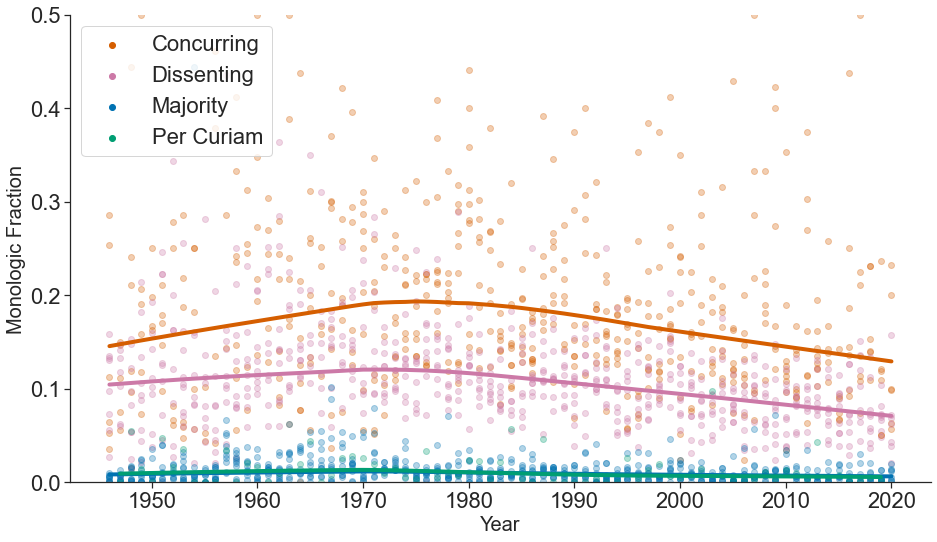

In [ ]:
trends_over_years_by_author(author_by_year_individualistic, year_col = "year", prediction_col="individualistic", category_col="category")

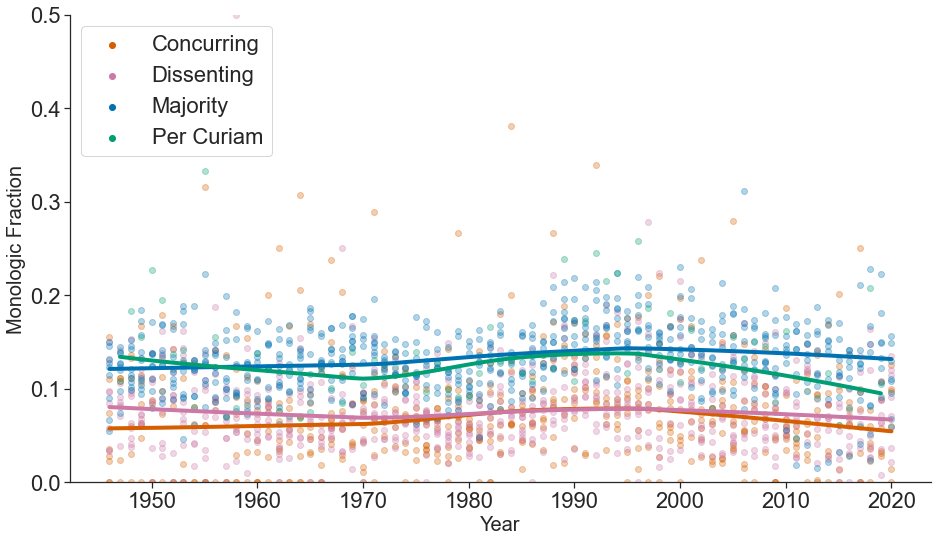

In [ ]:
trends_over_years_by_author(author_by_year_collective, "year", "collective", "category")

In [ ]:
def plot_heatmap_by_category(df):
    sns.set(style='ticks', font_scale=2)
    plt.subplots(figsize=(15,20)) 
    mask = df.isnull()
    column_labels = ["Individualistic", "Collective"]
    cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True, reverse=True)
    graph = sns.heatmap(df, 
                robust=True,
                mask=mask,
                xticklabels=column_labels,
                #cmap = cmap
                cmap = "Blues"
               )
    graph.set_facecolor('lightgrey')
    #plt.xlabel('Category')
    plt.ylabel(' ')
    #plt.title("Percentage Monologic Voice by Category")
    plt.tight_layout()
    sns.despine()
    plt.savefig(output_path + '/type_by_justice', dpi = 300)
    plt.show()

In [ ]:
individual_by_opinion = df_filtered.groupby(['opinion_num', 'year'], as_index=False)['individualistic'].mean()
collective_by_opinion = df_filtered.groupby(['opinion_num', 'year'], as_index=False)['collective'].mean()

In [ ]:
# merge per opinion with metadata
def create_subsets_by_chief_justice(per_opinion):
    vinson_court = per_opinion[per_opinion["year"] <= 1953]
    warren_court = per_opinion[(per_opinion["year"] >= 1954) & (per_opinion["year"] <= 1968)]
    burger_court = per_opinion[(per_opinion["year"] >= 1969) & (per_opinion["year"] <= 1985)]
    rehnquist_court = per_opinion[(per_opinion["year"] >= 1986) & (per_opinion["year"] <= 2005)]
    roberts_court = per_opinion[(per_opinion["year"] >= 2006)]

    return vinson_court, warren_court, burger_court, rehnquist_court, roberts_court

In [ ]:
ind_vinson_court, ind_warren_court, ind_burger_court, ind_rehnquist_court, ind_roberts_court = create_subsets_by_chief_justice(individual_by_opinion)
col_vinson_court, col_warren_court, col_burger_court, col_rehnquist_court, col_roberts_court = create_subsets_by_chief_justice(collective_by_opinion)

In [ ]:
from statistics import mean, stdev
from math import sqrt

def cohens_d(values_1, values_2):
    cohens_d = (mean(values_1) - mean(values_2)) / (sqrt((stdev(values_1) ** 2 + stdev(values_2) ** 2) / 2))
    return cohens_d

def summary_stats(df, col, name):
    col_ave = round(mean(df[col]), 3)
    col_std = round(stdev(df[col]), 3)
    name = name

    print(f"Stats for {name} for the {col} voice: \n Mean: {col_ave}, Standard Deviation: {col_std}. \n")

    return col_ave, col_std
    
    

In [ ]:
ind_vins_ave, ind_vins_std = summary_stats(ind_vinson_court, col = "individualistic", name = "Vinson")
ind_war_ave, ind_war_std = summary_stats(ind_warren_court, col = "individualistic", name = "Warren")
ind_bur_ave, ind_bur_std = summary_stats(ind_burger_court, col = "individualistic", name = "Burger")
ind_reh_ave, ind_reh_std = summary_stats(ind_rehnquist_court, col = "individualistic", name = "Rehnquist")
ind_rob_ave, ind_rob_std = summary_stats(ind_roberts_court, col = "individualistic", name = "Roberts")

Stats for Vinson for the individualistic voice: 
 Mean: 0.075, Standard Deviation: 0.131. 

Stats for Warren for the individualistic voice: 
 Mean: 0.116, Standard Deviation: 0.187. 

Stats for Burger for the individualistic voice: 
 Mean: 0.122, Standard Deviation: 0.182. 

Stats for Rehnquist for the individualistic voice: 
 Mean: 0.118, Standard Deviation: 0.189. 

Stats for Roberts for the individualistic voice: 
 Mean: 0.079, Standard Deviation: 0.131. 



In [ ]:
col_vins_ave, col_vins_std = summary_stats(col_vinson_court, col = "collective", name = "Vinson")
col_war_ave, col_war_std = summary_stats(col_warren_court, col = "collective", name = "Warren")
col_bur_ave, col_bur_std = summary_stats(col_burger_court, col = "collective", name = "Burger")
col_reh_ave, col_reh_std = summary_stats(col_rehnquist_court, col = "collective", name = "Rehnquist")
col_rob_ave, col_rob_std = summary_stats(col_roberts_court, col = "collective", name = "Roberts")

Stats for Vinson for the collective voice: 
 Mean: 0.11, Standard Deviation: 0.075. 

Stats for Warren for the collective voice: 
 Mean: 0.104, Standard Deviation: 0.086. 

Stats for Burger for the collective voice: 
 Mean: 0.096, Standard Deviation: 0.075. 

Stats for Rehnquist for the collective voice: 
 Mean: 0.117, Standard Deviation: 0.081. 

Stats for Roberts for the collective voice: 
 Mean: 0.102, Standard Deviation: 0.075. 



In [ ]:
stats_data = [["vinson", ind_vins_ave, ind_vins_std, col_vins_ave, col_vins_std], ["warren", ind_war_ave, ind_war_std, col_war_ave, col_war_std], ["burger", ind_bur_ave, ind_bur_std, col_bur_ave, col_bur_std], 
["rehnquist", ind_reh_ave, ind_reh_std, col_reh_ave, col_reh_std], ["roberts", ind_rob_ave, ind_rob_std, col_rob_ave, col_rob_std]]

In [ ]:
court_stats_df = pd.DataFrame(stats_data, columns = ["Chief Justice", "Individualistic Mean", "Individualistic Standard Deviation", "Collective Mean", "Collective Standard Deviation"])

In [ ]:
court_stats_df

,Chief Justice,Individualistic Mean,Individualistic Standard Deviation,Collective Mean,Collective Standard Deviation
0,vinson,0.075,0.131,0.110,0.075
1,warren,0.116,0.187,0.104,0.086
2,burger,0.122,0.182,0.096,0.075
3,rehnquist,0.118,0.189,0.117,0.081
4,roberts,0.079,0.131,0.102,0.075


In [ ]:
court_stats_df.to_csv(os.path.join(output_path, "court_stats.csv"))

### Rehnquist - Roberts Justices

In [ ]:
def remove_hyphen(string_to_split):
    name = string_to_split.split("-")[1]
    return name

In [ ]:
roberts_only_group = df_filtered[df_filtered["roberts_justice"] == "Roberts Court"]
roberts_only_group.author.unique()

array(['Roberts', 'Kagan', 'Gorsuch', 'Alito', 'Kavanaugh', 'Sotomayor'],
      dtype=object)

In [ ]:
rehnquist_roberts_group = df_filtered[df_filtered["roberts_justice"]=="Rehnquist - Roberts Court"]
rehnquist_roberts_group["split_author"] = rehnquist_roberts_group["split_author"].apply(remove_hyphen)
individual_rehn_rob = rehnquist_roberts_group.groupby(['split_author','opinion_num', 'year'], as_index=False)['individualistic'].mean()
collective_rehn_rob = rehnquist_roberts_group.groupby(['split_author','opinion_num', 'year'], as_index=False)['collective'].mean()

<ipython-input-49-5c50b7867c6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rehnquist_roberts_group["split_author"] = rehnquist_roberts_group["split_author"].apply(remove_hyphen)


### Cohen's d effect size

In [ ]:
def get_effect_size(df1, df2, col, df1_name, df2_name):
    effect = round(cohens_d(df1[col].to_list(), df2[col].to_list()), 3)
    df1_name = df1_name
    df2_name = df2_name 
    print(f"{col} effect size between {df1_name} and {df2_name}: {effect}")

    return effect


In [ ]:
# OVERALL STATS
rehnquist_roberts_group = rehnquist_roberts_group[rehnquist_roberts_group["author"] != "O'Connor"]

In [ ]:
name = "All Justices"
indi_before_rehnquist = rehnquist_roberts_group[rehnquist_roberts_group["year"] < 2006]
indi_before_average, indi_before_std = summary_stats(indi_before_rehnquist, col = "individualistic", name = name)
indi_after_rehnquist = rehnquist_roberts_group[rehnquist_roberts_group["year"] > 2005]
indi_after_average, indi_after_std = summary_stats(indi_after_rehnquist, col = "individualistic", name = name)
print(f"Before stats for {name} for the individualistic voice: \n Mean: {indi_before_average}, Standard Deviation: {indi_before_std}. \n")
print(f"After stats for {name} for the individualistic voice: \n Mean: {indi_after_average}, Standard Deviation: {indi_after_std}. \n")
ind_stat, ind_p = ttest_ind(indi_before_rehnquist["individualistic"], indi_after_rehnquist["individualistic"])
if ind_p > 0.05:
    ind_sig = "NS"
else:
    ind_sig = "S"
individual_effect = get_effect_size(indi_before_rehnquist, indi_after_rehnquist, col = "individualistic", df1_name = "pre-"+name, df2_name = "post-"+name)


coll_before_rehnquist = rehnquist_roberts_group[rehnquist_roberts_group["year"] < 2006]
coll_before_average, coll_before_std = summary_stats(coll_before_rehnquist, col = "collective", name = name)
coll_after_rehnquist = rehnquist_roberts_group[rehnquist_roberts_group["year"] > 2005]
coll_after_average, coll_after_std = summary_stats(coll_after_rehnquist, col = "collective", name = name)
print(f"Before stats for {name} for the collective voice: \n Mean: {coll_before_average}, Standard Deviation: {coll_before_std}. \n")
print(f"After stats for {name} for the collective voice: \n Mean: {coll_after_average}, Standard Deviation: {coll_after_std}. \n")
coll_stat, coll_p = ttest_ind(coll_before_rehnquist["collective"], coll_after_rehnquist["collective"])
if coll_p > 0.05:
    coll_sig = "NS"
else:
    coll_sig = "S"
collective_effect = get_effect_size(coll_before_rehnquist, coll_after_rehnquist, col = "collective", df1_name = "pre-"+name, df2_name = "post-"+name)

case = {'justice': name,'individual_effect': individual_effect, 'collective_effect': collective_effect}
#effect_list.append(case)

single_stats_data = [
    name, 
    indi_before_average, 
    indi_after_average, 
    indi_before_std, 
    indi_after_std, 
    ind_p,
    ind_sig,
    individual_effect, 
    coll_before_average, 
    coll_after_average, 
    coll_before_std, 
    coll_after_std, 
    coll_p,
    coll_sig,
    collective_effect
    ]

stats_data.append(single_stats_data)


stats_df = pd.DataFrame(
stats_data, 
columns = [
"Chief Justice", 
"Individualistic Before Mean", 
"Individualistic After Mean", 
"Individualistic Before Standard Deviation", 
"Individualistic After Standard Deviation", 
"Individualistic p-value",
"Individualistic Significance",
"Individualistic Effect", 
"Collective Before Mean", 
"Collective After Mean",  
"Collective Before Standard Deviation", 
"Collective After Standard Deviation", 
"Collective p-value",
"Collective Significance",
"Collective Effect"
]
)

stats_df

Stats for All Justices for the individualistic voice: 
 Mean: 0.055, Standard Deviation: 0.229. 

Stats for All Justices for the individualistic voice: 
 Mean: 0.043, Standard Deviation: 0.202. 

Before stats for All Justices for the individualistic voice: 
 Mean: 0.055, Standard Deviation: 0.229. 

After stats for All Justices for the individualistic voice: 
 Mean: 0.043, Standard Deviation: 0.202. 

individualistic effect size between pre-All Justices and post-All Justices: 0.059
Stats for All Justices for the collective voice: 
 Mean: 0.122, Standard Deviation: 0.327. 

Stats for All Justices for the collective voice: 
 Mean: 0.096, Standard Deviation: 0.294. 

Before stats for All Justices for the collective voice: 
 Mean: 0.122, Standard Deviation: 0.327. 

After stats for All Justices for the collective voice: 
 Mean: 0.096, Standard Deviation: 0.294. 

collective effect size between pre-All Justices and post-All Justices: 0.084


,Chief Justice,Individualistic Before Mean,Individualistic After Mean,Individualistic Before Standard Deviation,Individualistic After Standard Deviation,Individualistic p-value,Individualistic Significance,Individualistic Effect,Collective Before Mean,Collective After Mean,Collective Before Standard Deviation,Collective After Standard Deviation,Collective p-value,Collective Significance,Collective Effect
0,vinson,0.075,0.131,0.110,0.075,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
1,warren,0.116,0.187,0.104,0.086,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
2,burger,0.122,0.182,0.096,0.075,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
3,rehnquist,0.118,0.189,0.117,0.081,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
4,roberts,0.079,0.131,0.102,0.075,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
5,All Justices,0.055,0.043,0.229,0.202,2.311379e-89,S,0.059,0.122,0.096,0.327,0.294,3.595971e-176,S,0.084


In [ ]:
effect_list = []
stats_data = []

for name in list(rehnquist_roberts_group.split_author.unique()):
    if name != "O'Connor":
        print("Stats for Justice "+name)
        # group as individualistic before and afer rehnquist; get effect size
        indi_author_only = individual_rehn_rob[individual_rehn_rob["split_author"] == name]
        indi_before_rehnquist = indi_author_only[indi_author_only["year"] < 2006]
        indi_before_average, indi_before_std = summary_stats(indi_before_rehnquist, col = "individualistic", name = name)
        indi_after_rehnquist = indi_author_only[indi_author_only["year"] > 2005]
        indi_after_average, indi_after_std = summary_stats(indi_after_rehnquist, col = "individualistic", name = name)
        print(f"Before stats for {name} for the individualistic voice: \n Mean: {indi_before_average}, Standard Deviation: {indi_before_std}. \n")
        print(f"After stats for {name} for the individualistic voice: \n Mean: {indi_after_average}, Standard Deviation: {indi_after_std}. \n")
        ind_stat, ind_p = ttest_ind(indi_before_rehnquist["individualistic"], indi_after_rehnquist["individualistic"])
        if ind_p > 0.05:
            ind_sig = "NS"
        else:
            ind_sig = "S"
        individual_effect = get_effect_size(indi_before_rehnquist, indi_after_rehnquist, col = "individualistic", df1_name = "pre-"+name, df2_name = "post-"+name)

        # group as collective before and after rehnquist; get effect size
        coll_author_only = collective_rehn_rob[individual_rehn_rob["split_author"] == name]
        coll_before_rehnquist = coll_author_only[coll_author_only["year"] < 2006]
        coll_before_average, coll_before_std = summary_stats(coll_before_rehnquist, col = "collective", name = name)
        coll_after_rehnquist = coll_author_only[coll_author_only["year"] > 2005]
        coll_after_average, coll_after_std = summary_stats(coll_after_rehnquist, col = "collective", name = name)
        print(f"Before stats for {name} for the collective voice: \n Mean: {coll_before_average}, Standard Deviation: {coll_before_std}. \n")
        print(f"After stats for {name} for the collective voice: \n Mean: {coll_after_average}, Standard Deviation: {coll_after_std}. \n")
        coll_stat, coll_p = ttest_ind(coll_before_rehnquist["collective"], coll_after_rehnquist["collective"])
        if coll_p > 0.05:
            coll_sig = "NS"
        else:
            coll_sig = "S"
        collective_effect = get_effect_size(coll_before_rehnquist, coll_after_rehnquist, col = "collective", df1_name = "pre-"+name, df2_name = "post-"+name)

        case = {'justice': name,'individual_effect': individual_effect, 'collective_effect': collective_effect}
        effect_list.append(case)

        single_stats_data = [
            name, 
            indi_before_average, 
            indi_after_average, 
            indi_before_std, 
            indi_after_std, 
            ind_p,
            ind_sig,
            individual_effect, 
            coll_before_average, 
            coll_after_average, 
            coll_before_std, 
            coll_after_std, 
            coll_p,
            coll_sig,
            collective_effect
            ]

        stats_data.append(single_stats_data)

    else:
        print("skip o'connor")

stats_df = pd.DataFrame(
    stats_data, 
    columns = [
        "Chief Justice", 
        "Individualistic Before Mean", 
        "Individualistic After Mean", 
        "Individualistic Before Standard Deviation", 
        "Individualistic After Standard Deviation", 
        "Individualistic p-value",
        "Individualistic Significance",
        "Individualistic Effect", 
        "Collective Before Mean", 
        "Collective After Mean",  
        "Collective Before Standard Deviation", 
        "Collective After Standard Deviation", 
        "Collective p-value",
        "Collective Significance",
        "Collective Effect"
        ]
        )

Stats for Justice Thomas
Stats for Thomas for the individualistic voice: 
 Mean: 0.107, Standard Deviation: 0.167. 

Stats for Thomas for the individualistic voice: 
 Mean: 0.109, Standard Deviation: 0.162. 

Before stats for Thomas for the individualistic voice: 
 Mean: 0.107, Standard Deviation: 0.167. 

After stats for Thomas for the individualistic voice: 
 Mean: 0.109, Standard Deviation: 0.162. 

individualistic effect size between pre-Thomas and post-Thomas: -0.014
Stats for Thomas for the collective voice: 
 Mean: 0.123, Standard Deviation: 0.083. 

Stats for Thomas for the collective voice: 
 Mean: 0.097, Standard Deviation: 0.07. 

Before stats for Thomas for the collective voice: 
 Mean: 0.123, Standard Deviation: 0.083. 

After stats for Thomas for the collective voice: 
 Mean: 0.097, Standard Deviation: 0.07. 

collective effect size between pre-Thomas and post-Thomas: 0.337
Stats for Justice Breyer
Stats for Breyer for the individualistic voice: 
 Mean: 0.102, Standard De

In [ ]:
stats_df

,Chief Justice,Individualistic Before Mean,Individualistic After Mean,Individualistic Before Standard Deviation,Individualistic After Standard Deviation,Individualistic p-value,Individualistic Significance,Individualistic Effect,Collective Before Mean,Collective After Mean,Collective Before Standard Deviation,Collective After Standard Deviation,Collective p-value,Collective Significance,Collective Effect
0,Thomas,0.107,0.109,0.167,0.162,0.870573,NS,-0.014,0.123,0.097,0.083,0.070,8.142782e-05,S,0.337
1,Breyer,0.102,0.085,0.159,0.126,0.219034,NS,0.120,0.095,0.124,0.068,0.098,7.575905e-04,S,-0.340
2,Kennedy,0.086,0.045,0.141,0.092,0.001158,S,0.337,0.143,0.050,0.087,0.051,8.508982e-31,S,1.296
3,Ginsburg,0.080,0.063,0.141,0.137,0.210031,NS,0.124,0.090,0.077,0.069,0.057,2.900059e-02,S,0.217
4,Scalia,0.155,0.095,0.196,0.118,0.000024,S,0.374,0.126,0.119,0.084,0.068,2.961554e-01,NS,0.088
5,Stevens,0.152,0.106,0.192,0.127,0.012612,S,0.285,0.097,0.117,0.083,0.083,1.186970e-02,S,-0.251
6,Souter,0.096,0.100,0.175,0.205,0.905479,NS,-0.017,0.103,0.106,0.069,0.100,7.622794e-01,NS,-0.041


In [ ]:
stats_df.to_csv(os.path.join(output_path, "pre-post_roberts_stats.csv"))

In [ ]:
individual_rob = roberts_only_group.groupby(['author','opinion_num', 'year'], as_index=False)['individualistic'].mean()
collective_rob = roberts_only_group.groupby(['author','opinion_num', 'year'], as_index=False)['collective'].mean()

In [ ]:
for name in list(roberts_only_group.author.unique()):
    print("Stats for Justice "+name)

Stats for Justice Roberts
Stats for Justice Kagan
Stats for Justice Gorsuch
Stats for Justice Alito
Stats for Justice Kavanaugh
Stats for Justice Sotomayor


In [ ]:
summary_stats(individual_rob[individual_rob["author"] == name], col = "individualistic", name = "Roberts")

Stats for Roberts for the individualistic voice: 
 Mean: 0.069, Standard Deviation: 0.108. 



(0.069, 0.108)

In [ ]:

roberts_stats_data = []
for name in list(roberts_only_group.author.unique()):
    print("Stats for Justice "+name)

    indi_author_only = individual_rob[individual_rob["author"] == name]
    indi_average, indi_std = summary_stats(indi_author_only, col = "individualistic", name = name)

    coll_author_only = collective_rob[collective_rob["author"] == name]
    coll_average, coll_std = summary_stats(coll_author_only, col = "collective", name = name)



    single_stats_data = [
                name, 
                indi_average,
                indi_std,
                coll_average,
                coll_std
    ]

    roberts_stats_data.append(single_stats_data)


roberts_stats_df = pd.DataFrame(
    roberts_stats_data, 
    columns = [
        "Author", 
        "Individualistic Mean",
        "Individualistic Stand. Dev.",
        "Collective Mean",
        "Collective Stand. Dev."
        ]
        )
    

roberts_stats_df


Stats for Justice Roberts
Stats for Roberts for the individualistic voice: 
 Mean: 0.085, Standard Deviation: 0.119. 

Stats for Roberts for the collective voice: 
 Mean: 0.112, Standard Deviation: 0.067. 

Stats for Justice Kagan
Stats for Kagan for the individualistic voice: 
 Mean: 0.032, Standard Deviation: 0.049. 

Stats for Kagan for the collective voice: 
 Mean: 0.126, Standard Deviation: 0.064. 

Stats for Justice Gorsuch
Stats for Gorsuch for the individualistic voice: 
 Mean: 0.049, Standard Deviation: 0.08. 

Stats for Gorsuch for the collective voice: 
 Mean: 0.139, Standard Deviation: 0.051. 

Stats for Justice Alito
Stats for Alito for the individualistic voice: 
 Mean: 0.077, Standard Deviation: 0.141. 

Stats for Alito for the collective voice: 
 Mean: 0.106, Standard Deviation: 0.072. 

Stats for Justice Kavanaugh
Stats for Kavanaugh for the individualistic voice: 
 Mean: 0.066, Standard Deviation: 0.092. 

Stats for Kavanaugh for the collective voice: 
 Mean: 0.113, S

,Author,Individualistic Mean,Individualistic Stand. Dev.,Collective Mean,Collective Stand. Dev.
0,Roberts,0.085,0.119,0.112,0.067
1,Kagan,0.032,0.049,0.126,0.064
2,Gorsuch,0.049,0.080,0.139,0.051
3,Alito,0.077,0.141,0.106,0.072
4,Kavanaugh,0.066,0.092,0.113,0.058
5,Sotomayor,0.069,0.108,0.091,0.071


In [ ]:
output_path

'/Users/rosamondthalken/Documents/Projects/SupremeCourt/SupremeCourtPython/individualistic_vs_collective'

In [ ]:
roberts_stats_df.to_csv(os.path.join(output_path, "roberts_stats.csv"))

In [ ]:
col_effect_vinson_warren = get_effect_size(col_vinson_court, col_warren_court, col = "collective", df1_name = "Vinson", df2_name = "Warren")
col_effect_warren_burger = get_effect_size(col_warren_court, col_burger_court, col = "collective", df1_name = "Warren", df2_name = "Burger")
col_effect_burger_rehnquist = get_effect_size(col_burger_court, col_rehnquist_court, col = "collective", df1_name = "Burger", df2_name = "Rehnquist")
col_effect_rehnquist_roberts = get_effect_size(col_rehnquist_court, col_roberts_court, col = "collective", df1_name = "Rehnquist", df2_name = "Roberts")

collective effect size between Vinson and Warren: 0.076
collective effect size between Warren and Burger: 0.098
collective effect size between Burger and Rehnquist: -0.274
collective effect size between Rehnquist and Roberts: 0.192


In [ ]:
ind_effect_vinson_warren = get_effect_size(ind_vinson_court, ind_warren_court, col = "individualistic", df1_name = "Vinson", df2_name = "Warren")
ind_effect_warren_burger = get_effect_size(ind_warren_court, ind_burger_court, col = "individualistic", df1_name = "Warren", df2_name = "Burger")
ind_effect_burger_rehnquist = get_effect_size(ind_burger_court, ind_rehnquist_court, col = "individualistic", df1_name = "Burger", df2_name = "Rehnquist")
ind_effect_rehnquist_roberts = get_effect_size(ind_rehnquist_court, ind_roberts_court, col = "individualistic", df1_name = "Rehnquist", df2_name = "Roberts")

individualistic effect size between Vinson and Warren: -0.254
individualistic effect size between Warren and Burger: -0.035
individualistic effect size between Burger and Rehnquist: 0.022
individualistic effect size between Rehnquist and Roberts: 0.239


In [ ]:
effect_data = [["vinson_warren", col_effect_vinson_warren, ind_effect_vinson_warren], ["warren_burger", col_effect_warren_burger, ind_effect_warren_burger], ["burger_rehnquist", col_effect_burger_rehnquist, ind_effect_burger_rehnquist],
["rehnquist_roberts", col_effect_rehnquist_roberts, ind_effect_rehnquist_roberts]]

In [ ]:
effect_df = pd.DataFrame(effect_data, columns = ["Courts", "Collective Effect", "Individualistic Effect"])

For each opinion, get the mean of sentences predicted as individualistic and opinion. Then, group opinion means by Court and find overall Court averages and standard deviations.

In [ ]:
effect_df.to_csv(os.path.join(output_path, "indi_coll_effect.csv"))
effect_df

,Courts,Collective Effect,Individualistic Effect
0,vinson_warren,0.076,-0.254
1,warren_burger,0.098,-0.035
2,burger_rehnquist,-0.274,0.022
3,rehnquist_roberts,0.192,0.239


In [ ]:
ind_not_roberts_court = individual_by_opinion[(individual_by_opinion["year"] < 2006)]
col_not_roberts_court = collective_by_opinion[(collective_by_opinion["year"] < 2006)]

In [ ]:
ind_stat, ind_p = ttest_ind(ind_roberts_court["individualistic"], ind_not_roberts_court["individualistic"])

In [ ]:
if ind_p > 0.05:
	print(f'Probably the same distribution, p value = {ind_p}')
else:
	print(f'Probably different distributions, p value = {ind_p}')

Probably different distributions, p value = 1.2479885659966916e-16


In [ ]:
col_stat, col_p = ttest_ind(col_roberts_court["collective"], col_not_roberts_court["collective"])

In [ ]:
if col_p > 0.05:
	print(f'Probably the same distribution, p value = {col_p} n')
else:
	print(f'Probably different distributions, p value = {col_p}')

Probably the same distribution, p value = 0.05336987327589457 n


### Fightin Words

In [ ]:
#from nltk import stops
import nltk
from nltk.corpus import stopwords
# print(stopwords.words('english'))
stopwords = stopwords.words('english')

remove_from_stops = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'they', 'them', 'their', 'theirs', 'themselves','he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself']

stopwords_best = [token for token in stopwords if token not in remove_from_stops]
print(stopwords_best)

['it', "it's", 'its', 'itself', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 

In [ ]:
import string
exclude = set(string.punctuation)
from sklearn.feature_extraction.text import CountVectorizer as CV

def basic_sanitize(in_string):
    '''Returns a very roughly sanitized version of the input string.'''
    return_string = ''.join([char for char in in_string if ord(char) < 128 and char not in exclude]).lower()
    return_string = ' '.join([word for word in return_string.split() if word not in stopwords_best])
    return return_string

def bayes_compare_language(l1, l2, output_path, ngram=1, prior=.01, cv=None, sig_val=2.573):
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.
    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''
    if cv is None and type(prior) is not float:
        print("If using a non-uniform prior:")
        print("Please also pass a count vectorizer with the vocabulary parameter set.")
        quit()
    l1 = [basic_sanitize(l) for l in l1]
    l2 = [basic_sanitize(l) for l in l2]

    if cv is None:
        cv = CV(
            decode_error = 'ignore', 
            min_df = 10, 
            max_df = .9, 
            ngram_range=(1,ngram),
            binary = False,
            max_features = 1500)
    counts_mat = cv.fit_transform(l1+l2).toarray()
    # Now sum over languages...
    vocab_size = len(cv.vocabulary_)
    print("Vocab size is {}".format(vocab_size))
    if type(prior) is float:
        priors = np.array([prior for i in range(vocab_size)])
    else:
        priors = prior
    z_scores = np.empty(priors.shape[0])
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)
    count_matrix[0, :] = np.sum(counts_mat[:len(l1), :], axis = 0)
    count_matrix[1, :] = np.sum(counts_mat[len(l1):, :], axis = 0)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(count_matrix[0,:])
    n2 = 1.*np.sum(count_matrix[1,:])
    print("Comparing language...")
    for i in range(vocab_size):
        #compute delta
        term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
        term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))        
        delta = term1 - term2
        #compute variance on delta
        var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
    index_to_term = {v: k for k, v in cv.vocabulary_.items()}
    sorted_indices = np.argsort(z_scores)
    return_list = [(index_to_term[i], z_scores[i]) for i in sorted_indices]
    

    # plotting z scores and frequencies
    x_vals = count_matrix.sum(axis=0)
    y_vals = z_scores
    sizes = abs(z_scores) * 2
    neg_color, pos_color, insig_color = ('#340509', '#053430', '#d8d8d8')
    colors = []
    annots = []
    for i, y in enumerate(y_vals):
        if y > sig_val:
            colors.append(pos_color)
            annots.append(index_to_term[i])
        elif y < -sig_val:
            colors.append(neg_color)
            annots.append(index_to_term[i])
        else:
            colors.append(insig_color)
            annots.append(None)

    
    fig, ax = plt.subplots(figsize=(14,20))
    ax.scatter(x_vals, y_vals, c=colors, linewidth=0, alpha = 0.4)

    for i, annot in enumerate(annots):
        if annot is not None:
            if np.abs(y_vals[i]) > 5:
                ax.annotate(annot, (x_vals[i], y_vals[i]), color='black', fontsize=12)

    ax.set_xscale('log')
    plt.xlabel("Word Frequency")
    plt.ylabel("z-score (log scale)")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(output_path, 'fightin_words.png'), dpi = 300)

    return return_list, cv.vocabulary_


In [ ]:
individualistic_list = df_filtered[df_filtered["individualistic"] == 1].text.to_list()
collective_list = df_filtered[df_filtered["collective"] == 1].text.to_list()

Vocab size is 1500
Comparing language...


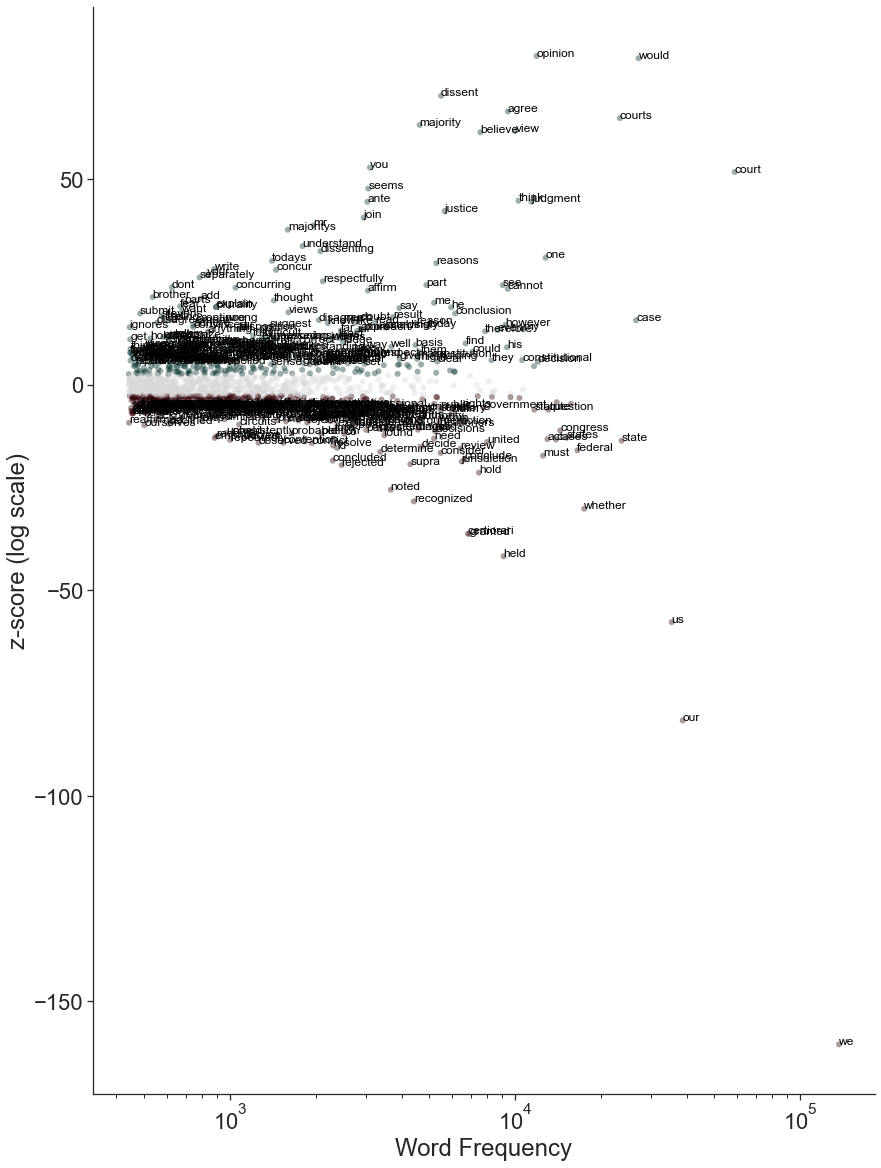

In [ ]:
output_list, vocabulary = bayes_compare_language(individualistic_list, collective_list, output_path)
z_scores_df = pd.DataFrame(output_list)

In [ ]:
z_scores_df.to_csv(os.path.join(output_path, 'z_scores_fightin_words.csv'))

### Top Cases

In [ ]:
df_long_opinion = df[df["length"] >20]
individualistic_mean = pd.DataFrame(df_long_opinion.groupby(["opinion_num", "case", "category", "year", "author", "length"])["individualistic"].mean())

collective_mean = pd.DataFrame(df_long_opinion.groupby(["opinion_num", "case", "category", "year", "author", "length"])["collective"].mean())

In [ ]:
# merge collective_mean and individualistic_mean on opinion_num, create new column that's an average of individualistic and collective scores
opinion_means_combined = pd.merge(collective_mean, individualistic_mean, on=["opinion_num", "case", "category", "year", "author", "length"]).reset_index()
opinion_means_combined.individualistic

0        0.002203
1        0.145833
2        0.069252
3        0.254545
4        0.004132
           ...   
13293    0.000000
13294    0.000000
13295    0.000000
13296    0.000000
13297    0.000000
Name: individualistic, Length: 13298, dtype: float64

In [ ]:
def get_column_average(col1, col2):
    individualistic_score = col1
    collective_score = col2
    average_score = (individualistic_score + collective_score) / 2

    return average_score

def get_sum_square_values(col1, col2):
    individualistic_score = col1
    collective_score = col2
    balanced_score = pow(individualistic_score, 2) + pow(collective_score, 2)

    return balanced_score

def add_columns(col1, col2):
    individualistic_score = col1
    collective_score = col2
    added_score = col1 + col2

    return added_score

def get_difference(col1, col2):
    individualistic_score = col1
    collective_score = col2
    difference = abs(col1 - col2)

    return difference

In [ ]:
opinion_means_combined["average"] = opinion_means_combined.apply(lambda x: get_column_average(x['individualistic'], x['collective']), axis=1)
opinion_means_combined["balance"] = opinion_means_combined.apply(lambda x: get_sum_square_values(x['individualistic'], x['collective']), axis=1)
opinion_means_combined["added"] = opinion_means_combined.apply(lambda x: add_columns(x['individualistic'], x['collective']), axis=1)
opinion_means_combined["difference"] = opinion_means_combined.apply(lambda x: get_difference(x['individualistic'], x['collective']), axis=1)


In [ ]:
pd.set_option('display.max_rows', 100)

In [ ]:
high_means = opinion_means_combined[opinion_means_combined["added"] > .0]
high_means.sort_values('difference', ascending=True).head(50)

,opinion_num,case,category,year,author,length,collective,individualistic,average,balance,added,difference
11152,14276,Spencer v. Kemna,Dissenting,1998,Justice Stevens,22,0.166667,0.166667,0.166667,0.055556,0.333333,0.0
6041,7690,Autry v. Estelle,Dissenting,1983,Justice Stevens,30,0.185185,0.185185,0.185185,0.068587,0.370370,0.0
2284,2909,National Ins. Co. v. Tidewater Co.,Dissenting,1949,Justice Frankfurter,95,0.031915,0.031915,0.031915,0.002037,0.063830,0.0
11104,14211,Chisom v. Roemer,Dissenting,1991,Justice Scalia,157,0.169118,0.169118,0.169118,0.057202,0.338235,0.0
11072,14173,Delo v. Blair,Dissenting,1993,Justice Blackmun,27,0.095238,0.095238,0.095238,0.018141,0.190476,0.0
6058,7711,"Texas Dept. of Housing and Community Affairs v. Inclusive Communities Project, Inc.",Dissenting,2015,Justice Thomas,148,0.115942,0.115942,0.115942,0.026885,0.231884,0.0
2269,2888,Dougherty County Bd. of Ed. v. White,Dissenting,1978,Justice Powell,96,0.044444,0.044444,0.044444,0.003951,0.088889,0.0
11048,14141,Cleavinger v. Saxner,Dissenting,1985,Justice Rehnquist,46,0.119048,0.119048,0.119048,0.028345,0.238095,0.0
2938,3734,"FW/PBS, Inc. v. Dallas",Concurring,1990,Justice Brennan,283,0.170040,0.170040,0.170040,0.057828,0.340081,0.0
224,287,Class v. United States,Dissenting,2018,Justice Alito,221,0.104396,0.104396,0.104396,0.021797,0.208791,0.0


In [ ]:
opinion_means_combined[opinion_means_combined["category"] == "Majority"].sort_values(by=['average'], ascending=False).head(200)

,opinion_num,case,category,year,author,length,collective,individualistic,average,balance,added,difference
2011,2562,Leyra v. Denno,Majority,1954,Justice Black,1007,0.037962,0.550450,0.294206,0.304436,0.588412,0.512488
11974,15325,Dixon v. Duffy,Majority,1952,Justice Vinson,35,0.451613,0.032258,0.241935,0.204995,0.483871,0.419355
8708,11144,Chapman v. California,Majority,1967,Justice Black,287,0.167883,0.288321,0.228102,0.111314,0.456204,0.120438
13133,16793,Lynumn v. Illinois,Majority,1963,Justice Stewart,120,0.118182,0.327273,0.222727,0.121074,0.445455,0.209091
78,103,MacKey v. United States,Majority,1971,Justice White,315,0.145329,0.283737,0.214533,0.101627,0.429066,0.138408
...,...,...,...,...,...,...,...,...,...,...,...,...
4122,5253,Wieman v. Updegraff,Majority,1952,Justice Clark,83,0.256757,0.027027,0.141892,0.066654,0.283784,0.229730
12502,15985,Landreth Timber Co. v. Landreth,Majority,1985,Justice Powell,158,0.283582,0.000000,0.141791,0.080419,0.283582,0.283582
5465,6961,Illinois v. Gates,Majority,1983,Justice Rehnquist,293,0.283465,0.000000,0.141732,0.080352,0.283465,0.283465
6803,8684,Hewitt v. Helms,Majority,1983,Justice Rehnquist,168,0.255034,0.026846,0.140940,0.065763,0.281879,0.228188


In [ ]:
opinion_means_combined.sort_values(by=['average'], ascending=False).head(100).to_csv(os.path.join(output_path, "top_combined_opinions.csv"))

In [ ]:
individualistic_mean.sort_values(by=['individualistic'], ascending=False).head(100).to_csv(os.path.join(output_path, "top_individualistic_opinions.csv"))

In [ ]:
collective_mean.sort_values(by=['collective'], ascending=False).head(100).to_csv(os.path.join(output_path, "top_collective_opinions.csv"))

## Label Relationships

In [34]:
import os
import matplotlib.pyplot as plt
output_path = os.path.join(os.getcwd(), 'individualistic_vs_collective')

In [51]:
import plotly.graph_objects as go

fig = go.Figure(go.Treemap(
    labels = ["All Sentences", "Not Rhetoric","Rhetoric", "Monologic", "Not Monologic", "Individualistic", "Collective"],
    parents = ["", "All Sentences", "All Sentences", "Rhetoric", "Rhetoric", "Monologic", "Monologic"],
    values = [100,54, 46, 19, 27, 5, 14],
    branchvalues="total",
    marker_colors = ["#a8a1a1", "#c1bcbc", "#c1bcbc", "#d9d6d6", "#d9d6d6", "white", "white"]
    #marker_colors = ["#4f117c", "#9570b0", "#9570b0", "#b89fca", 
    #                 "#b89fca", "white", "white"],
    #width=1000,
    #height=1000,
    #width = 500,
    #height = 500,
    #marker_colorscale = 'Blues'
    #color_discrete_map={"Not Rhetoric": "lightgrey","Rhetoric": "lightgrey", "Monologic": "lightgrey", "Not Monologic": "lightgrey", "Individualistic": "lightgrey", "Collective": "lightgrey"}
))

fig.update_layout(width=900,height=500,margin = dict(t=25, l=25, r=25, b=25), uniformtext=dict(minsize=12, mode = 'hide'))
fig.data[0]['textfont']['color'] = "black"
plt.savefig(os.path.join(output_path, 'treemap.png'), dpi = 600)
#fig.write_image(os.path.join(output_path, 'treemap.png'), scale = 1)
fig.show();

<Figure size 432x288 with 0 Axes>

## Seniority and Salience

In [ ]:
martin_quinn = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'martin_quinn.csv'))
salience_df = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'all_metadata.csv'))

/Users/rosamondthalken/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning:

Columns (62) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
martin_quinn_mean = pd.DataFrame(martin_quinn.groupby(["justiceName"])["post_mn"].mean())
scd_list_names = list(martin_quinn_mean.index)

In [ ]:
# create justice matcher
# create justice matcher
def match_scd_author(df_col):
    try:
        if df_col == "Justice O'Connor":
            scd_name = "SDOConnor"
        else:
            match = re.search(r'Justice (\S+)', df_col)
            last_name = match.group(1)
            for name in scd_list_names:
                if last_name in name:
                    scd_name = name
    except AttributeError:
        scd_name = "Per Curiam"      
    return scd_name


In [ ]:
per_curiam = ["per_curiam", "Justice Vinson"]
df_filtered = df[~df['author'].isin(per_curiam)]
df_filtered = df_filtered.drop(df_filtered[(df_filtered['author'] == "Justice Jackson") & (df_filtered['year'] == 1964)].index)


df_indi = df_filtered.groupby(['opinion_num', 'category','author', 'case', 'year'])['individualistic'].mean().reset_index()
df_collective = df_filtered.groupby(['opinion_num', 'category','author', 'case', 'year'])['collective'].mean().reset_index()


In [ ]:
df_indi_author = df_indi.groupby(['author'])['individualistic'].mean().reset_index()
df_coll_author = df_collective.groupby(['author'])['collective'].mean().reset_index()

In [ ]:
author_mean = pd.merge(df_indi_author, df_coll_author, on = "author")

In [ ]:
# ideology
#author_mean = author_mean.reset_index()
author_mean["scd_name"] = author_mean.apply(lambda row: match_scd_author(row["author"]),axis=1)

In [ ]:
from scipy.stats import pearsonr
martin_quinn_mean = martin_quinn_mean.reset_index()
# merge df and martin_quinn_ave
justice_monologic_ideology = author_mean.merge(martin_quinn_mean, left_on = "scd_name", right_on = "justiceName")
individualistic_array = justice_monologic_ideology["individualistic"].array
collective_array = justice_monologic_ideology["collective"].array
ideology_array = justice_monologic_ideology["post_mn"].array
coll_corr, coll_sig = pearsonr(collective_array, ideology_array)

indi_corr, indi_sig = pearsonr(individualistic_array, ideology_array)


In [ ]:
print("Collective correlation: "+ str(coll_corr) + " with a significance of " + str(coll_sig))
print("Individualistic correlation: "+ str(indi_corr) + " with a significance of " + str(indi_sig))

Collective correlation: 0.19515260908447396 with a significance of 0.24707030195168048
Individualistic correlation: 0.07988467123886527 with a significance of 0.6383594004723813


**Takeaway:** Overall, the collective tone is more correlated with conservative ideology, but neither of these are significant.

In [ ]:
# Ideology by year

indi_by_year = df_filtered.groupby(["author", "year", "chief_justice"], as_index=False)["individualistic"].mean()
coll_by_year = df_filtered.groupby(["author", "year", "chief_justice"], as_index=False)["collective"].mean()

author_by_year = pd.merge(indi_by_year, coll_by_year, on = ["author", "year", "chief_justice"])
author_by_year["scd_name"] = author_by_year.apply(lambda row: match_scd_author(row["author"]),axis=1)

In [ ]:
author_by_year

,author,year,chief_justice,individualistic,collective,scd_name
0,Justice Alito,2006,Roberts,0.028662,0.112527,SAAlito
1,Justice Alito,2007,Roberts,0.021277,0.125601,SAAlito
2,Justice Alito,2008,Roberts,0.067476,0.105825,SAAlito
3,Justice Alito,2009,Roberts,0.026316,0.099104,SAAlito
4,Justice Alito,2010,Roberts,0.030880,0.102620,SAAlito
...,...,...,...,...,...,...
679,Justice Whittaker,1958,Warren,0.047868,0.080030,CEWhittaker
680,Justice Whittaker,1959,Warren,0.036705,0.105220,CEWhittaker
681,Justice Whittaker,1960,Warren,0.081327,0.065712,CEWhittaker
682,Justice Whittaker,1961,Warren,0.053788,0.071212,CEWhittaker


In [ ]:
year_monologic_ideology = pd.merge(author_by_year, martin_quinn,  how='left', left_on=['scd_name','year'], right_on = ['justiceName','term'])

In [ ]:
year_monologic_ideology

,author,year,chief_justice,individualistic,collective,scd_name,term,justice,justiceName,post_mn,post_sd,post_med,post_025,post_975
0,Justice Alito,2006,Roberts,0.028662,0.112527,SAAlito,2006.0,112.0,SAAlito,1.465,0.296,1.454,0.921,2.085
1,Justice Alito,2007,Roberts,0.021277,0.125601,SAAlito,2007.0,112.0,SAAlito,1.559,0.295,1.541,1.007,2.155
2,Justice Alito,2008,Roberts,0.067476,0.105825,SAAlito,2008.0,112.0,SAAlito,1.817,0.290,1.812,1.278,2.410
3,Justice Alito,2009,Roberts,0.026316,0.099104,SAAlito,2009.0,112.0,SAAlito,1.855,0.309,1.848,1.274,2.490
4,Justice Alito,2010,Roberts,0.030880,0.102620,SAAlito,2010.0,112.0,SAAlito,1.996,0.324,1.995,1.373,2.642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,Justice Whittaker,1958,Warren,0.047868,0.080030,CEWhittaker,1958.0,93.0,CEWhittaker,1.286,0.214,1.280,0.889,1.718
680,Justice Whittaker,1959,Warren,0.036705,0.105220,CEWhittaker,1959.0,93.0,CEWhittaker,1.370,0.213,1.366,0.969,1.793
681,Justice Whittaker,1960,Warren,0.081327,0.065712,CEWhittaker,1960.0,93.0,CEWhittaker,1.209,0.235,1.204,0.766,1.692
682,Justice Whittaker,1961,Warren,0.053788,0.071212,CEWhittaker,1961.0,93.0,CEWhittaker,1.147,0.333,1.136,0.523,1.815


In [ ]:
year_monologic_ideology = year_monologic_ideology.dropna()

In [ ]:
corr_indi_year, sig_indi_year = pearsonr(year_monologic_ideology["individualistic"].array, year_monologic_ideology["post_mn"].array)
corr_coll_year, sig_coll_year = pearsonr(year_monologic_ideology["collective"].array, year_monologic_ideology["post_mn"].array)



In [ ]:
print("Correlation between ideology and individualistic tone, by year: "+ str(corr_indi_year) + " with a significance of " + str(sig_indi_year))
print("Correlation between ideology and collective tone, by year: "+ str(corr_coll_year) + " with a significance of " + str(sig_coll_year))

Correlation between ideology and individualistic tone, by year: -0.0572896036040359 with a significance of 0.1493044583528319
Correlation between ideology and collective tone, by year: 0.14725904261589606 with a significance of 0.000196231278504602


**Takeaway:** There is a slight positive correlation between conservative ideology and collective tone, by year. This is a significant finding. 

In [ ]:
# by CJ

year_monologic_ideology.groupby('chief_justice')[['individualistic','post_mn']].corr()

individualistic   post_mn
chief_justice                                           
Burger        individualistic         1.000000 -0.181452
              post_mn                -0.181452  1.000000
Rehnquist     individualistic         1.000000  0.035811
              post_mn                 0.035811  1.000000
Roberts       individualistic         1.000000  0.218240
              post_mn                 0.218240  1.000000
Vinson        individualistic         1.000000 -0.204305
              post_mn                -0.204305  1.000000
Warren        individualistic         1.000000 -0.016610
              post_mn                -0.016610  1.000000

In [ ]:
year_monologic_ideology.groupby('chief_justice')[['collective','post_mn']].corr()

collective   post_mn
chief_justice                                 
Burger        collective    1.000000  0.224061
              post_mn       0.224061  1.000000
Rehnquist     collective    1.000000  0.366190
              post_mn       0.366190  1.000000
Roberts       collective    1.000000  0.029443
              post_mn       0.029443  1.000000
Vinson        collective    1.000000  0.152275
              post_mn       0.152275  1.000000
Warren        collective    1.000000 -0.194284
              post_mn      -0.194284  1.000000

In [ ]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 7)
    return pvalues

In [ ]:
year_monologic_ideology.groupby('chief_justice')[['collective','post_mn']].apply(calculate_pvalues)

collective   post_mn
chief_justice                                
Burger        collective        0.0   0.00568
              post_mn       0.00568       0.0
Rehnquist     collective        0.0  0.000002
              post_mn      0.000002       0.0
Roberts       collective        0.0  0.752668
              post_mn      0.752668       0.0
Vinson        collective        0.0  0.225919
              post_mn      0.225919       0.0
Warren        collective        0.0  0.019629
              post_mn      0.019629       0.0

In [ ]:
year_monologic_ideology.groupby('chief_justice')[['individualistic','post_mn']].apply(calculate_pvalues)

individualistic   post_mn
chief_justice                                          
Burger        individualistic             0.0  0.025766
              post_mn                0.025766       0.0
Rehnquist     individualistic             0.0  0.655091
              post_mn                0.655091       0.0
Roberts       individualistic             0.0  0.018086
              post_mn                0.018086       0.0
Vinson        individualistic             0.0   0.10258
              post_mn                 0.10258       0.0
Warren        individualistic             0.0  0.843357
              post_mn                0.843357       0.0

**Takeaways:** 
* There is slight positive correlation (0.21) between conservative ideology and individualistic tone in the Roberts Court. This is not significant. 
* There is no correlation (0.03) between conservative ideology and collective tone in the Roberts Court. This is not significant.
* There is a higher (0.37) correlation between the Rehnquist Court's collective tone and conservative ideology. This is significant.
* There is no correlation (0.04) between the Rehnquist Court's individualistic tone and conservative ideology. This is significant. 

## Seniority

In [ ]:
first_year_df = pd.DataFrame(df_filtered.groupby("author")["year"].min()).reset_index()
first_year_df = first_year_df.rename(columns={"year":"first_year"})
seniority_year = author_by_year.merge(first_year_df, on = "author")

In [ ]:
seniority_year["year_on_court"] = seniority_year["year"] - seniority_year["first_year"]
seniority_year

,author,year,chief_justice,individualistic,collective,scd_name,first_year,year_on_court
0,Justice Alito,2006,Roberts,0.028662,0.112527,SAAlito,2006,0
1,Justice Alito,2007,Roberts,0.021277,0.125601,SAAlito,2006,1
2,Justice Alito,2008,Roberts,0.067476,0.105825,SAAlito,2006,2
3,Justice Alito,2009,Roberts,0.026316,0.099104,SAAlito,2006,3
4,Justice Alito,2010,Roberts,0.030880,0.102620,SAAlito,2006,4
...,...,...,...,...,...,...,...,...
679,Justice Whittaker,1958,Warren,0.047868,0.080030,CEWhittaker,1957,1
680,Justice Whittaker,1959,Warren,0.036705,0.105220,CEWhittaker,1957,2
681,Justice Whittaker,1960,Warren,0.081327,0.065712,CEWhittaker,1957,3
682,Justice Whittaker,1961,Warren,0.053788,0.071212,CEWhittaker,1957,4


In [ ]:
sen_coll_corr, sen_coll_sig = pearsonr(seniority_year["collective"].array, seniority_year["year_on_court"].array)
sen_indi_corr, sen_indi_sig = pearsonr(seniority_year["individualistic"].array, seniority_year["year_on_court"].array)

print("Correlation between seniority and collective tone: " + str(sen_coll_corr) + " with a significance of " + str(sen_coll_sig))
print("Correlation between seniority and individualitic tone: " + str(sen_indi_corr) + " with a significance of " + str(sen_indi_sig))

Correlation between seniority and collective tone: 0.005056814923889853 with a significance of 0.8949749411861335
Correlation between seniority and individualitic tone: 0.03128705143481475 with a significance of 0.4139478811825586


**Takeaway:** There is no correlation between seniority and collective or individualistic tones. 

## Salience

In [ ]:
salience_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0_x,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,...,Unnamed: 0_y,salienceData.caseId,salience.est,salience.sd,early.salience.est,early.salience.sd,probit.salience.est,probit.salience.sd,nytSalience,cqSalience
0,0,0,1555,1955-001,1955-001-01,1955-001-01-01,1955-001-01-01-01,10/10/1955,2,350 U.S. 1,...,1,1955-001,-0.482810,0.818406,-0.190841,0.885945,-0.500808,0.799667,0,0
1,1,1,1556,1955-002,1955-002-01,1955-002-01-01,1955-002-01-01-01,10/17/1955,2,350 U.S. 3,...,2,1955-002,-0.419444,0.810166,-0.232832,0.904265,-0.508252,0.785026,0,0
2,2,2,1557,1955-004,1955-004-01,1955-004-01-01,1955-004-01-01-01,11/7/1955,1,350 U.S. 11,...,4,1955-004,-0.459178,0.822925,-0.265416,0.901517,-0.498846,0.784875,1,0
3,3,3,1558,1955-004,1955-004-01,1955-004-01-01,1955-004-01-01-01,11/7/1955,1,350 U.S. 11,...,4,1955-004,-0.459178,0.822925,-0.265416,0.901517,-0.498846,0.784875,1,0
4,4,4,1559,1955-004,1955-004-01,1955-004-01-01,1955-004-01-01-01,11/7/1955,1,350 U.S. 11,...,4,1955-004,-0.459178,0.822925,-0.265416,0.901517,-0.498846,0.784875,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12605,12605,12605,14165,2008-081,2008-081-01,2008-081-01-01,2008-081-01-01-01,6/25/2009,1,557 U.S. 433,...,7179,2008-081,0.487528,0.492451,0.501604,0.561179,0.701541,0.438540,0,0
12606,12606,12606,14166,2008-082,2008-082-01,2008-082-01-01,2008-082-01-01-01,6/29/2009,1,557 U.S. 519,...,7180,2008-082,-0.854459,0.746576,-0.652630,0.779601,-0.923974,0.676330,0,0
12607,12607,12607,14167,2008-083,2008-083-01,2008-083-01-01,2008-083-01-01-01,6/29/2009,1,557 U.S. 557,...,7181,2008-083,2.625259,0.214877,2.323859,0.250203,2.987232,0.528275,1,1
12608,12608,12608,14168,2008-083,2008-083-01,2008-083-01-01,2008-083-01-01-01,6/29/2009,1,557 U.S. 557,...,7181,2008-083,2.625259,0.214877,2.323859,0.250203,2.987232,0.528275,1,1


In [ ]:
df_for_merging = salience_df[['case_name', 'salience.est', 'nytSalience', 'cqSalience']]
df_for_merging = df_for_merging.drop_duplicates()

In [ ]:
opinion_individualistic = df.groupby(['case', 'year', 'chief_justice'], as_index=False)['individualistic'].mean()
opinion_collective = df.groupby(['case', 'year','chief_justice'], as_index=False)['collective'].mean()


In [ ]:
salience_individualistic_opinion = opinion_individualistic.merge(df_for_merging, left_on = "case", right_on = "case_name")
salience_collective_opinion = opinion_collective.merge(df_for_merging, left_on = "case", right_on = "case_name")


In [ ]:
non_salient_individualistic = salience_individualistic_opinion[salience_individualistic_opinion['nytSalience'] == 0]['individualistic']
salient_individualistic = salience_individualistic_opinion[salience_individualistic_opinion['nytSalience'] == 1]['individualistic']

non_salient_collective = salience_collective_opinion[salience_collective_opinion['nytSalience'] == 0]['collective']
salient_collective = salience_collective_opinion[salience_collective_opinion['nytSalience'] == 1]['collective']

In [ ]:
import scipy.stats as stats
stats.ttest_ind(non_salient_individualistic, salient_individualistic)

Ttest_indResult(statistic=-7.881382947382655, pvalue=3.694208271890278e-15)

In [ ]:
stats.ttest_ind(non_salient_collective, salient_collective)

Ttest_indResult(statistic=-1.2555585337027888, pvalue=0.20931515178556498)

In [ ]:
import researchpy as rp
rp.ttest(non_salient_individualistic, salient_individualistic)[0]

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,individualistic,6551.0,0.041159,0.049112,0.000607,0.039970,0.042349
1,individualistic,958.0,0.054386,0.044228,0.001429,0.051581,0.057190
2,combined,7509.0,0.042847,0.048713,0.000562,0.041745,0.043949


In [ ]:
rp.ttest(non_salient_individualistic, salient_individualistic)[1]

,Independent t-test,results
0,Difference (individualistic - individualistic) =,-0.0132
1,Degrees of freedom =,7507.0000
2,t =,-7.8814
3,Two side test p value =,0.0000
4,Difference < 0 p value =,0.0000
5,Difference > 0 p value =,1.0000
6,Cohen's d =,-0.2726
7,Hedge's g =,-0.2726
8,Glass's delta =,-0.2693
9,Pearson's r =,0.0906


In [ ]:
rp.ttest(non_salient_collective, salient_collective)[0]

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,collective,6551.0,0.116545,0.071571,0.000884,0.114812,0.118279
1,collective,958.0,0.119577,0.056352,0.001821,0.116005,0.123150
2,combined,7509.0,0.116932,0.069818,0.000806,0.115353,0.118512


In [ ]:
rp.ttest(non_salient_collective, salient_collective)[1]

,Independent t-test,results
0,Difference (collective - collective) =,-0.0030
1,Degrees of freedom =,7507.0000
2,t =,-1.2556
3,Two side test p value =,0.2093
4,Difference < 0 p value =,0.1047
5,Difference > 0 p value =,0.8953
6,Cohen's d =,-0.0434
7,Hedge's g =,-0.0434
8,Glass's delta =,-0.0424
9,Pearson's r =,0.0145


**Takeaway:** I *think* the individualistic tone is used more often in salient cases, with statistical significance. High (maybe?) t, cohen's d.

## Division and Unanimity

In [ ]:
votes_df = salience_df[["case_name", "scdb_votes_majority", "scdb_votes_minority"]]

In [ ]:
def check_if_unanimous(df_col):
    if(df_col == 0):
        return 1
    else:
        return 0

votes_df["unanimous"] = votes_df["scdb_votes_minority"].apply(check_if_unanimous)

<ipython-input-139-3d2f5dd534b7>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
Counter(votes_df.scdb_votes_minority)

Counter({0.0: 3265, 3.0: 2937, 2.0: 2253, 4.0: 2574, 1.0: 1581})

In [ ]:
# get correlation between a case's overall individualistic count and the number of minority votes

division_individualistic_opinion = opinion_individualistic.merge(votes_df, left_on = "case", right_on = "case_name").drop_duplicates()
division_collective_opinion = opinion_collective.merge(votes_df, left_on = "case", right_on = "case_name").drop_duplicates()

In [ ]:
minority_votes_by_year = division_individualistic_opinion.groupby('year')["scdb_votes_minority"].mean().array
individualistic_by_year = division_individualistic_opinion.groupby('year')['individualistic'].mean().array
collective_by_year = division_collective_opinion.groupby('year')['collective'].mean().array

In [ ]:
pearsonr(minority_votes_by_year, individualistic_by_year)

(0.07506620730707503, 0.525005799596135)

In [ ]:
pearsonr(minority_votes_by_year, collective_by_year)

(-0.19772902156160077, 0.09127918338785757)

In [ ]:
#division_individualistic_opinion = division_individualistic_opinion.drop_duplicates()
#division_collective_opinion = division_collective_opinion.drop_duplicates()

In [ ]:
print("Correlation between divided decisions and the collective tone: " + str(pearsonr(division_collective_opinion.collective.array, division_collective_opinion.scdb_votes_minority.array)))

Correlation between division decision and the collective tone(-0.12848968211202802, 1.6223764542722145e-28)


In [ ]:
print("Correlation between divided decisions and the individualistic tone: " + str(pearsonr(division_individualistic_opinion.individualistic.array, division_individualistic_opinion.scdb_votes_minority.array)))

Correlation between divided decisions and the individualistic tone(0.3048232394481918, 2.462044097651945e-158)


**Takeaways:** 
* With significance, there is positive correlation between division and the individualistic tone.
* With significance, there is negative correlation between division and the collective tone.

In [ ]:
unanimous_by_year = division_individualistic_opinion.groupby('year')['unanimous'].mean().array



In [ ]:
print("Correlation between unanimity and the individualistic tone: " + str(pearsonr(unanimous_by_year, individualistic_by_year)))

Correlation between unanimity and the individualistic tone(-0.09662587840153136, 0.4128006806138162)


In [ ]:
print("Correlation between unanimity and the collective tone: " + str(pearsonr(unanimous_by_year, collective_by_year)))

Correlation between unanimity and the collective tone: (0.1962358914128035, 0.09380063033891453)


**Takeaway:**
* Insignificant differences with unanimity and the individualistic tone. 
* Significant positive correlation between unanimity and the collective tone. 

## Stimson's Mood

In [ ]:
working_dir = os.getcwd()
stimson = pd.read_csv(os.path.join(working_dir, 'Data', 'stimson_mood.csv'))

In [ ]:
stimson

,Year,Mood2020
0,1952,49.361
1,1953,53.977
2,1954,58.192
3,1955,61.918
4,1956,60.389
5,1957,56.903
6,1958,61.917
7,1959,63.914
8,1960,63.380
9,1961,67.395


In [ ]:
individualistic_df = pd.DataFrame(division_individualistic_opinion.groupby('year')["individualistic"].mean())
collective_df = pd.DataFrame(division_collective_opinion.groupby('year')["collective"].mean())

combined_by_year = individualistic_df.merge(collective_df, on = "year")


In [ ]:
stimson_combined_df = combined_by_year.merge(stimson, left_on="year", right_on = "Year")

In [ ]:
stimson_mood = stimson_combined_df.Mood2020.array
individualistic_mood = stimson_combined_df.individualistic.array
collective_mood = stimson_combined_df.collective.array

In [ ]:
pearsonr(stimson_mood, individualistic_mood)

(-0.3881248159790832, 0.0010737814805261508)

In [ ]:
pearsonr(stimson_mood, collective_mood)

(0.24048032566343863, 0.048225160342723436)